In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install ultralytics # install
from ultralytics import YOLO, checks
import os, torch, json, math
from PIL import Image, ImageDraw
import numpy as np
from tqdm import tqdm
from torch import nn, Tensor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.optim as optim
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/hemp/download/model')
from mobilenet import mobilenetv4_conv_medium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.8/906.8 kB 43.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **이미지 전처리(암꽃 분할)**

In [7]:
checks()

model_path = '/content/drive/MyDrive/Colab Notebooks/hemp/download/model/yolo.pt'
model = YOLO(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/112.6 GB disk)
cuda


In [8]:
img_dir = '/content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images'
output_dir = '/content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/seg_images'
os.makedirs(output_dir, exist_ok=True)

file_names = os.listdir(img_dir)

for file_name in tqdm(file_names, desc="Processing segmentation", leave=False):
    img_path = os.path.join(img_dir, file_name)
    output_path = os.path.join(output_dir, os.path.splitext(file_name)[0] + ".png")

    results = model.predict(img_path, conf=0.8)

    if not results or not hasattr(results[0], 'boxes') or not hasattr(results[0], 'masks'):
        print(f"{img_path} not saved: No detections")
        continue

    boxes = results[0].boxes
    masks = results[0].masks

    if boxes.conf is None or boxes.conf.numel() == 0:
        print(f"{img_path} not saved: No detections")
        continue

    max_conf_idx = boxes.conf.argmax().item()

    mask = masks.xy[max_conf_idx] if masks.xy else None

    if mask is not None and len(mask) > 0:
        try:
            img = Image.open(img_path).convert('RGB')

            mask_img = Image.new('L', img.size, 0)
            ImageDraw.Draw(mask_img).polygon(mask, fill=1)
            mask_array = np.array(mask_img)

            img_array = np.array(img)
            img_array[mask_array == 0] = 0

            seg_img = Image.fromarray(img_array)
            seg_img.save(output_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    else:
        print(f"{img_path} not saved: No mask detected")

Processing segmentation:   0%|          | 0/100 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_d05_A_2_3_22-10-06-11-15-1021.png: 480x640 1 flower, 17.7ms
Speed: 2.7ms preprocess, 17.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   1%|          | 1/100 [00:00<00:52,  1.90it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c02_A_2_5_22-10-05-10-43-1021.png: 480x640 1 flower, 19.4ms
Speed: 4.1ms preprocess, 19.4ms inference, 4.4ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   2%|▏         | 2/100 [00:00<00:46,  2.11it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c06_A_2_1_22-09-13-13-43-1011.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   3%|▎         | 3/100 [00:01<00:40,  2.41it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c02_A_2_4_22-09-20-11-13-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   4%|▍         | 4/100 [00:01<00:44,  2.16it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c04_A_1_1_22-10-04-09-22-1011.png: 480x640 1 flower, 16.9ms
Speed: 5.0ms preprocess, 16.9ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   5%|▌         | 5/100 [00:02<00:45,  2.08it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_a10_A_3_3_22-09-02-13-15-1020.png: 480x640 1 flower, 16.8ms
Speed: 4.1ms preprocess, 16.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   6%|▌         | 6/100 [00:02<00:46,  2.02it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_d07_B_1_1_22-08-26-11-31-1010.png: 480x640 1 flower, 19.8ms
Speed: 4.3ms preprocess, 19.8ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   7%|▋         | 7/100 [00:03<00:46,  1.99it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_a07_A_2_2_22-09-20-10-05-1031.png: 480x640 1 flower, 16.8ms
Speed: 4.0ms preprocess, 16.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   8%|▊         | 8/100 [00:03<00:46,  1.96it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c06_B_3_3_22-09-27-10-05-1021.png: 480x640 1 flower, 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   9%|▉         | 9/100 [00:04<00:46,  1.94it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_a09_B_2_1_22-08-24-13-23-1010.png: 480x640 1 flower, 16.9ms
Speed: 4.1ms preprocess, 16.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  10%|█         | 10/100 [00:04<00:44,  2.02it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c10_B_1_3_22-09-27-10-34-1010.png: 480x640 1 flower, 16.8ms
Speed: 4.0ms preprocess, 16.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  11%|█         | 11/100 [00:05<00:44,  2.01it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_d06_B_1_4_22-09-20-13-24-1031.png: 480x640 1 flower, 16.9ms
Speed: 4.1ms preprocess, 16.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  12%|█▏        | 12/100 [00:05<00:43,  2.00it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_a12_B_2_3_22-08-31-13-44-1010.png: 480x640 1 flower, 17.4ms
Speed: 5.3ms preprocess, 17.4ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  13%|█▎        | 13/100 [00:06<00:39,  2.19it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_a14_A_2_4_22-09-26-09-55-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  14%|█▍        | 14/100 [00:06<00:37,  2.30it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b07_B_1_4_22-09-26-09-28-1010.png: 480x640 1 flower, 16.9ms
Speed: 2.7ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  15%|█▌        | 15/100 [00:07<00:35,  2.41it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c11_B_1_1_22-08-26-10-13-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  16%|█▌        | 16/100 [00:07<00:33,  2.48it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_a10_A_3_5_22-10-06-09-47-1021.png: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  17%|█▋        | 17/100 [00:07<00:32,  2.53it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_b01_A_1_2_22-09-15-13-23-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  18%|█▊        | 18/100 [00:08<00:30,  2.67it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_a02_A_1_2_22-09-02-11-20-1020.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  19%|█▉        | 19/100 [00:08<00:31,  2.61it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_a06_B_2_8_22-09-26-14-26-1021.png: 480x640 1 flower, 18.7ms
Speed: 4.0ms preprocess, 18.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  20%|██        | 20/100 [00:08<00:29,  2.67it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c04_B_2_1_22-09-19-10-30-1021.png: 480x640 1 flower, 16.8ms
Speed: 2.4ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  21%|██        | 21/100 [00:09<00:28,  2.82it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b10_A_3_7_22-09-26-15-43-1021.png: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  22%|██▏       | 22/100 [00:09<00:28,  2.75it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_d10_A_3_4_22-10-06-11-29-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  23%|██▎       | 23/100 [00:09<00:26,  2.88it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_d13_B_2_4_22-09-28-10-05-1021.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  24%|██▍       | 24/100 [00:10<00:26,  2.88it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c07_B_2_2_22-09-30-10-20-1021.png: 480x640 1 flower, 16.9ms
Speed: 2.7ms preprocess, 16.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  25%|██▌       | 25/100 [00:10<00:27,  2.69it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c03_B_3_4_22-09-16-14-32-1031.png: 480x640 1 flower, 16.8ms
Speed: 3.7ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  26%|██▌       | 26/100 [00:11<00:45,  1.62it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c04_A_3_1_22-08-29-13-15-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  27%|██▋       | 27/100 [00:13<01:09,  1.05it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_d09_B_3_2_22-09-29-10-00-1021.png: 480x640 1 flower, 16.9ms
Speed: 3.9ms preprocess, 16.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  28%|██▊       | 28/100 [00:15<01:32,  1.29s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_b02_A_2_4_22-09-14-11-15-1031.png: 480x640 1 flower, 16.9ms
Speed: 4.2ms preprocess, 16.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  29%|██▉       | 29/100 [00:16<01:30,  1.28s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_a13_B_1_1_22-09-08-13-33-1020.png: 480x640 1 flower, 22.3ms
Speed: 4.7ms preprocess, 22.3ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  30%|███       | 30/100 [00:18<01:37,  1.39s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b07_A_3_1_22-10-07-09-25-1020.png: 480x640 1 flower, 30.6ms
Speed: 4.4ms preprocess, 30.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  31%|███       | 31/100 [00:21<01:59,  1.73s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_a05_B_3_1_22-08-24-11-21-1010.png: 480x640 1 flower, 28.7ms
Speed: 4.1ms preprocess, 28.7ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  32%|███▏      | 32/100 [00:22<01:55,  1.69s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_d03_B_2_1_22-10-06-10-32-1021.png: 480x640 1 flower, 30.4ms
Speed: 15.9ms preprocess, 30.4ms inference, 7.6ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  33%|███▎      | 33/100 [00:24<01:53,  1.70s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c11_B_1_1_22-08-24-10-41-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.4ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  34%|███▍      | 34/100 [00:27<02:20,  2.13s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_d05_A_1_2_22-09-30-09-20-1011.png: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  35%|███▌      | 35/100 [00:28<01:58,  1.82s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_d10_A_3_3_22-10-07-11-00-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  36%|███▌      | 36/100 [00:29<01:45,  1.65s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_a10_A_3_1_22-09-26-09-40-1020.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  37%|███▋      | 37/100 [00:31<01:37,  1.54s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c06_A_3_2_22-10-12-11-18-1021.png: 480x640 1 flower, 16.9ms
Speed: 4.3ms preprocess, 16.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  38%|███▊      | 38/100 [00:32<01:36,  1.55s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_b13_A_1_3_22-09-02-11-02-1020.png: 480x640 1 flower, 16.8ms
Speed: 4.2ms preprocess, 16.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  39%|███▉      | 39/100 [00:36<02:15,  2.23s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b13_B_2_4_22-10-12-10-42-1021.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  40%|████      | 40/100 [00:37<01:55,  1.92s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c12_B_2_1_22-10-06-13-32-1021.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  41%|████      | 41/100 [00:40<02:12,  2.24s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c05_B_2_1_22-08-30-14-08-1020.png: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  42%|████▏     | 42/100 [00:42<01:53,  1.95s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_a04_B_2_2_22-08-30-10-49-1020.png: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  43%|████▎     | 43/100 [00:43<01:36,  1.69s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b07_A_1_1_22-09-14-14-55-1020.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  44%|████▍     | 44/100 [00:46<01:58,  2.12s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_a02_B_1_1_22-10-03-09-53-1020.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  45%|████▌     | 45/100 [00:47<01:40,  1.83s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c09_B_2_2_22-08-31-13-53-1020.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  46%|████▌     | 46/100 [00:48<01:30,  1.67s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_a12_B_2_4_22-09-16-15-40-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  47%|████▋     | 47/100 [00:52<01:55,  2.18s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c07_B_1_3_22-09-30-10-20-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  48%|████▊     | 48/100 [00:53<01:38,  1.89s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c04_B_3_5_22-10-11-14-17-1021.png: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  49%|████▉     | 49/100 [00:54<01:26,  1.69s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_b11_B_3_1_22-08-25-11-02-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  50%|█████     | 50/100 [00:55<01:16,  1.52s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b11_B_1_1_22-09-21-13-44-1021.png: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  51%|█████     | 51/100 [00:56<01:10,  1.45s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b14_A_1_9_22-09-26-15-55-1021.png: 480x640 1 flower, 17.0ms
Speed: 4.2ms preprocess, 17.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  52%|█████▏    | 52/100 [00:58<01:17,  1.62s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b11_A_3_5_22-10-13-10-43-1031.png: 480x640 1 flower, 21.5ms
Speed: 5.1ms preprocess, 21.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  53%|█████▎    | 53/100 [01:00<01:11,  1.52s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c08_B_2_5_22-09-15-10-09-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  54%|█████▍    | 54/100 [01:01<01:05,  1.42s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b10_A_1_1_22-09-05-13-27-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  55%|█████▌    | 55/100 [01:02<01:02,  1.39s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b02_B_2_7_22-09-26-09-10-1020.png: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  56%|█████▌    | 56/100 [01:04<01:01,  1.40s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_b12_B_1_5_22-09-19-10-41-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  57%|█████▋    | 57/100 [01:05<00:57,  1.34s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c07_B_2_1_22-08-29-13-36-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  58%|█████▊    | 58/100 [01:06<00:54,  1.30s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b07_A_1_2_22-09-26-15-32-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  59%|█████▉    | 59/100 [01:07<00:51,  1.25s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c08_B_2_1_22-08-31-13-49-1020.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  60%|██████    | 60/100 [01:09<00:54,  1.37s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_b06_A_3_6_22-09-16-15-37-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  61%|██████    | 61/100 [01:10<00:51,  1.32s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_b01_B_1_3_22-08-30-10-41-1020.png: 480x640 1 flower, 16.8ms
Speed: 3.9ms preprocess, 16.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  62%|██████▏   | 62/100 [01:11<00:51,  1.36s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_b08_B_2_2_22-08-31-10-08-1020.png: 480x640 1 flower, 16.9ms
Speed: 4.2ms preprocess, 16.9ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  63%|██████▎   | 63/100 [01:13<00:49,  1.34s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c10_A_3_3_22-09-28-10-00-1021.png: 480x640 1 flower, 17.3ms
Speed: 3.9ms preprocess, 17.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  64%|██████▍   | 64/100 [01:14<00:47,  1.33s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_b09_A_3_2_22-09-19-13-31-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  65%|██████▌   | 65/100 [01:15<00:44,  1.28s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_d01_B_2_1_22-10-05-11-18-1011.png: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  66%|██████▌   | 66/100 [01:16<00:42,  1.24s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c12_A_1_3_22-09-30-10-01-1021.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  67%|██████▋   | 67/100 [01:18<00:40,  1.23s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_d05_B_1_3_22-09-01-11-13-1020.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  68%|██████▊   | 68/100 [01:19<00:38,  1.20s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c06_A_2_2_22-09-21-10-15-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  69%|██████▉   | 69/100 [01:20<00:37,  1.20s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_a06_A_2_1_22-09-06-09-57-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  70%|███████   | 70/100 [01:21<00:37,  1.24s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_a03_B_2_1_22-09-21-14-08-1021.png: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  71%|███████   | 71/100 [01:23<00:42,  1.48s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_b06_B_3_1_22-08-30-10-53-1020.png: 480x640 1 flower, 16.8ms
Speed: 4.3ms preprocess, 16.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  72%|███████▏  | 72/100 [01:25<00:43,  1.57s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c06_A_3_1_22-08-31-10-37-1020.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  73%|███████▎  | 73/100 [01:26<00:41,  1.52s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_d04_A_3_1_22-08-29-13-51-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  74%|███████▍  | 74/100 [01:28<00:36,  1.40s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b07_A_1_1_22-09-28-10-27-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  75%|███████▌  | 75/100 [01:29<00:37,  1.52s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c13_B_1_1_22-09-22-11-24-1011.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  76%|███████▌  | 76/100 [01:30<00:33,  1.38s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_a03_B_2_1_22-08-25-10-27-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  77%|███████▋  | 77/100 [01:33<00:40,  1.78s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_a03_B_2_4_22-09-15-10-41-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  78%|███████▊  | 78/100 [01:34<00:35,  1.61s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_a05_B_1_1_22-08-29-10-31-1010.png: 480x640 1 flower, 16.9ms
Speed: 3.6ms preprocess, 16.9ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  79%|███████▉  | 79/100 [01:36<00:34,  1.63s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b04_A_1_1_22-09-29-09-40-1021.png: 480x640 1 flower, 16.8ms
Speed: 3.9ms preprocess, 16.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  80%|████████  | 80/100 [01:38<00:31,  1.58s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_a09_A_1_1_22-08-25-10-09-1010.png: 480x640 1 flower, 16.9ms
Speed: 4.4ms preprocess, 16.9ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  81%|████████  | 81/100 [01:39<00:29,  1.53s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b11_B_3_4_22-09-30-09-35-1020.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  82%|████████▏ | 82/100 [01:40<00:25,  1.43s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_d06_A_1_5_22-10-13-14-45-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  83%|████████▎ | 83/100 [01:42<00:24,  1.47s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_b03_B_1_5_22-09-15-09-57-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  84%|████████▍ | 84/100 [01:43<00:22,  1.38s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b01_B_3_4_22-09-29-09-34-1021.png: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  85%|████████▌ | 85/100 [01:44<00:19,  1.29s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_d04_B_2_1_22-09-07-10-26-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  86%|████████▌ | 86/100 [01:45<00:18,  1.32s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_a04_A_2_3_22-08-30-09-55-1020.png: 480x640 1 flower, 16.9ms
Speed: 2.9ms preprocess, 16.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  87%|████████▋ | 87/100 [01:46<00:16,  1.27s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_d11_B_2_4_22-10-06-10-53-1020.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  88%|████████▊ | 88/100 [01:48<00:16,  1.38s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_b13_B_3_1_22-09-06-13-16-1021.png: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  89%|████████▉ | 89/100 [01:50<00:16,  1.49s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_a09_B_3_4_22-10-05-10-16-1021.png: 480x640 1 flower, 16.8ms
Speed: 4.0ms preprocess, 16.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  90%|█████████ | 90/100 [01:51<00:14,  1.43s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b07_A_1_1_22-09-08-13-56-1010.png: 480x640 1 flower, 16.9ms
Speed: 2.8ms preprocess, 16.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  91%|█████████ | 91/100 [01:52<00:11,  1.33s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_c11_B_2_1_22-09-08-10-41-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  92%|█████████▏| 92/100 [01:53<00:10,  1.27s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_a08_B_2_3_22-10-03-10-02-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  93%|█████████▎| 93/100 [01:55<00:09,  1.35s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b14_B_3_1_22-10-03-10-58-1021.png: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  94%|█████████▍| 94/100 [01:56<00:07,  1.31s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c06_B_1_1_22-09-16-14-43-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  95%|█████████▌| 95/100 [01:57<00:06,  1.32s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c07_B_1_1_22-08-30-14-12-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  96%|█████████▌| 96/100 [01:59<00:05,  1.29s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_d10_A_2_1_22-09-05-10-46-1010.png: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  97%|█████████▋| 97/100 [02:00<00:03,  1.25s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_d05_B_3_2_22-09-13-10-33-1031.png: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  98%|█████████▊| 98/100 [02:01<00:02,  1.27s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/B_c14_A_1_1_22-08-23-11-31-1010.png: 480x640 1 flower, 16.9ms
Speed: 4.5ms preprocess, 16.9ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  99%|█████████▉| 99/100 [02:02<00:01,  1.26s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/images/A_b11_A_1_5_22-10-03-10-21-1031.png: 480x640 1 flower, 17.9ms
Speed: 4.3ms preprocess, 17.9ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


# **데이터셋 정의**

In [9]:
input_dir = '/content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/seg_images'
label_dir = '/content/drive/MyDrive/Colab Notebooks/hemp/download/dataset/labels'

def load_dataset(input_dir, label_dir):
    intput_files = os.listdir(input_dir)
    label_files = os.listdir(label_dir)

    dataset = []
    for input_file in intput_files:
        label_file = input_file.replace('.png', '.json')
        with open(os.path.join(label_dir, label_file), 'r') as f:
            label_data = json.load(f)
            browning = label_data['annotations']['polygon'][0]['browning']

        dataset.append({
            'image_path': os.path.join(input_dir, input_file),
            'label': f'{browning}'
        })
    return dataset

dataset = load_dataset(input_dir, label_dir)
labels = [data['label'] for data in dataset]

train_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_idx, temp_idx in train_split.split(dataset, labels):
    train_set = [dataset[i] for i in train_idx]
    temp_set = [dataset[i] for i in temp_idx]
val_test_split = StratifiedShuffleSplit(n_splits=1, test_size=2/3, random_state=42)
labels_temp = [labels[i] for i in temp_idx]
for val_idx, test_idx in val_test_split.split(temp_set, labels_temp):
    val_set = [temp_set[i] for i in val_idx]
    test_set = [temp_set[i] for i in test_idx]

train_label_count = Counter([data['label'] for data in train_set])
val_label_count   = Counter([data['label'] for data in val_set])
test_label_count  = Counter([data['label'] for data in test_set])

print("Train set class counts:", train_label_count)
print("Validation set class counts:", val_label_count)
print("Test set class counts:", test_label_count)

Train set class counts: Counter({'True': 35, 'False': 35})
Validation set class counts: Counter({'False': 5, 'True': 5})
Test set class counts: Counter({'False': 10, 'True': 10})


In [10]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=MEAN, std=STD)
transform = transforms.Compose([
    transforms.ToTensor()])

def preprocess_image(image):
    non_zero_mask = (image > 0).any(axis=-1)
    non_zero_rows = np.any(non_zero_mask, axis=1)
    non_zero_cols = np.any(non_zero_mask, axis=0)
    min_row, max_row = np.where(non_zero_rows)[0][[0, -1]]
    min_col, max_col = np.where(non_zero_cols)[0][[0, -1]]
    image = image[min_row:max_row+1, min_col:max_col+1]
    image = Image.fromarray(image)
    image = image.resize((224, 224))
    return image

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, num_classes=2):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert('RGB'))
        image = preprocess_image(image)
        label = int(self.labels[idx])

        if self.transform:
            image = self.transform(image)
        return image, label

def create_dataloader(dataset, transform, batch_size, shuffle, num_workers):
    image_paths = [item['image_path'] for item in dataset]
    labels = [0 if item['label'] == 'True' else 1 for item in dataset]
    custom_dataset = CustomDataset(image_paths, labels, transform=transform)
    return DataLoader(custom_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

train_loader = create_dataloader(train_set, transform, batch_size=24, shuffle=True, num_workers=2)
val_loader = create_dataloader(val_set, transform, batch_size=24, shuffle=False, num_workers=2)
test_loader = create_dataloader(test_set, transform, batch_size=24, shuffle=False, num_workers=2)

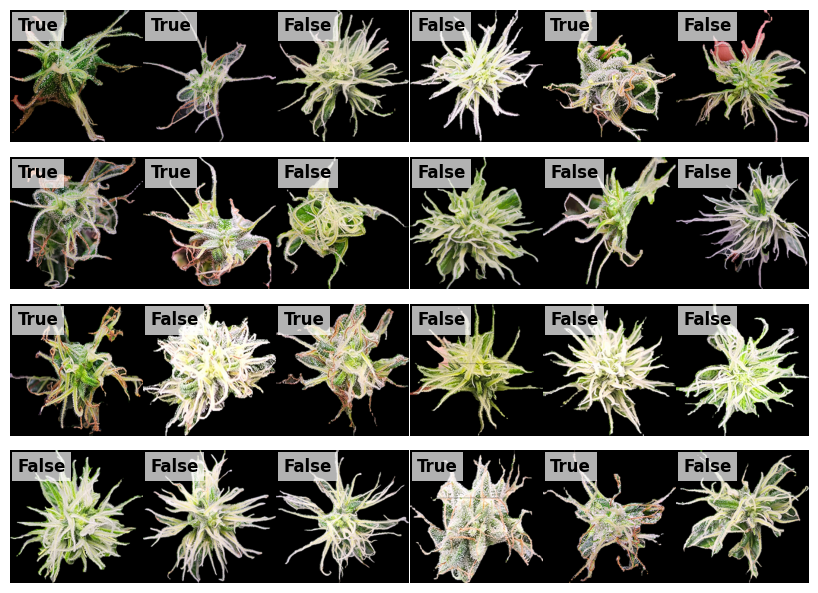

In [11]:
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(8, 6))
axes = axes.flatten()

for idx, img in enumerate(images):
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))

    axes[idx].imshow(img)
    axes[idx].axis('off')

    label = labels[idx].cpu().item()
    label_str = 'False' if label == 1 else 'True'

    axes[idx].text(
        12, 12, label_str,
        color='black', ha='left', va='top',
        fontsize=12, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

plt.tight_layout(pad=0.05, h_pad=0.05, w_pad=0.05)
plt.show()

# **모델 및 손실 함수 정의**

In [12]:
model = mobilenetv4_conv_medium(num_classes=2)
for params in model.parameters():
        params.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)

CE = nn.CrossEntropyLoss()

# **모델 학습**

In [13]:
model_dir = '/content/drive/MyDrive/Colab Notebooks/hemp/model'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'pretrain.pth')

num_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

def train_val_epoch(model, dataloader, phase, optimizer=None):
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(dataloader, desc=f'  {phase} Progress', leave=False):
        inputs = normalize(inputs).to(device)
        labels = labels.to(device)

        if phase == 'train':
            optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = CE(outputs, labels)
            _, preds = torch.max(outputs, 1)

            if phase == 'train':
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

    epoch_metrics = {
        'loss': epoch_loss,
        'accuracy': epoch_acc,
        'precision': epoch_precision,
        'recall': epoch_recall,
        'f1': epoch_f1
    }

    return epoch_loss, epoch_acc, epoch_metrics

best_model_wts = model.state_dict()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:")

    train_loss, train_acc, train_metrics = train_val_epoch(model, train_loader, 'train', optimizer)
    val_loss, val_acc, val_metrics = train_val_epoch(model, val_loader, 'val')

    print(f"  Train Metrics:      Loss={train_loss:.4f}, Acc={train_acc:.4f}, "
          f"Precision={train_metrics['precision']:.4f}, "
          f"Recall={train_metrics['recall']:.4f}, "
          f"F1={train_metrics['f1']:.4f}")
    print(f"  Validation Metrics: Loss={val_loss:.4f}, Acc={val_acc:.4f}, "
          f"Precision={val_metrics['precision']:.4f}, "
          f"Recall={val_metrics['recall']:.4f}, "
          f"F1={val_metrics['f1']:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_model_wts = model.state_dict()
        torch.save(best_model_wts, model_path)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"  Patience: {epochs_no_improve}")
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/50:


  Train Metrics:      Loss=0.6083, Acc=0.6714, Precision=0.6786, Recall=0.6714, F1=0.6681
  Validation Metrics: Loss=0.6939, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
Epoch 2/50:


  Train Metrics:      Loss=0.3331, Acc=0.8714, Precision=0.8717, Recall=0.8714, F1=0.8714
  Validation Metrics: Loss=0.9849, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
  Patience: 1
Epoch 3/50:


  Train Metrics:      Loss=0.1602, Acc=0.9429, Precision=0.9443, Recall=0.9429, F1=0.9428
  Validation Metrics: Loss=1.9909, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
  Patience: 2
Epoch 4/50:


  Train Metrics:      Loss=0.0779, Acc=0.9857, Precision=0.9861, Recall=0.9857, F1=0.9857
  Validation Metrics: Loss=3.2291, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
  Patience: 3
Epoch 5/50:


  Train Metrics:      Loss=0.0578, Acc=0.9714, Precision=0.9730, Recall=0.9714, F1=0.9714
  Validation Metrics: Loss=3.8273, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
  Patience: 4
Epoch 6/50:


  Train Metrics:      Loss=0.0621, Acc=0.9714, Precision=0.9730, Recall=0.9714, F1=0.9714
  Validation Metrics: Loss=4.1297, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
  Patience: 5
Early stopping at epoch 6


# **모델 추론 및 평가**

In [14]:
model = mobilenetv4_conv_medium(num_classes=2)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

total_loss = 0.0
correct_predictions = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Test Progress', leave=False):
        inputs = normalize(inputs).to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = CE(outputs, labels)
        _, preds = torch.max(outputs, 1)

        total_loss += loss.item() * inputs.size(0)
        correct_predictions += (preds == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

avg_test_loss = total_loss / len(test_loader.dataset)
avg_test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

print(f"Test Metrics: "
      f"Loss={avg_test_loss:.4f}, "
      f"Acc={avg_test_acc:.4f}, "
      f"Precision={test_precision:.4f}, "
      f"Recall={test_recall:.4f}, "
      f"F1={test_f1:.4f}")

Test Metrics: Loss=0.6939, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333


In [15]:
pretrained_model_path = '/content/drive/MyDrive/Colab Notebooks/hemp/download/model/pretrain.pth'
pretrained_model = mobilenetv4_conv_medium(num_classes=2)
pretrained_model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
pretrained_model.eval()

total_loss = 0.0
correct_predictions = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Test Progress', leave=False):
        inputs = normalize(inputs).to(device)
        labels = labels.to(device)

        outputs = pretrained_model(inputs)
        loss = CE(outputs, labels)
        _, preds = torch.max(outputs, 1)

        total_loss += loss.item() * inputs.size(0)
        correct_predictions += (preds == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

avg_test_loss = total_loss / len(test_loader.dataset)
avg_test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

print(f"Test Metrics: "
      f"Loss={avg_test_loss:.4f}, "
      f"Acc={avg_test_acc:.4f}, "
      f"Precision={test_precision:.4f}, "
      f"Recall={test_recall:.4f}, "
      f"F1={test_f1:.4f}")

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same